In [22]:
import pandas as pd
import numpy as np

# 1. Memory Reduction Function
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype != object:
            c_min, c_max = df[col].min(), df[col].max()
            if str(df[col].dtype)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
            else:
                df[col] = df[col].astype(np.float32)
    return df

# 2. Load the 5 files from your folder
print("Loading files...")
sales = reduce_mem_usage(pd.read_csv('m5_data/sales_train_evaluation.csv'))
calendar = reduce_mem_usage(pd.read_csv('m5_data/calendar.csv'))
prices = reduce_mem_usage(pd.read_csv('m5_data/sell_prices.csv'))

print("✅ Files loaded and memory optimized!")

Loading files...
✅ Files loaded and memory optimized!


In [23]:
# Melt the data from 'Wide' to 'Long' format
# We use only the last 500 days to ensure Colab has enough RAM
day_cols = [f'd_{i}' for i in range(1441, 1942)]

data = pd.melt(sales,
               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
               value_vars=day_cols,
               var_name='d', value_name='sales')

# Merge with calendar and prices
data = data.merge(calendar, on='d', how='left')
data = data.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')

print("✅ Data Merged! Current shape:", data.shape)
data.head()

✅ Data Merged! Current shape: (15275490, 22)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1441,2,2015-01-08,11449,...,1,2015,NaN,NaN,NaN,NaN,1,0,1,8.26
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1441,0,2015-01-08,11449,...,1,2015,NaN,NaN,NaN,NaN,1,0,1,3.97
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1441,0,2015-01-08,11449,...,1,2015,NaN,NaN,NaN,NaN,1,0,1,2.97
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1441,3,2015-01-08,11449,...,1,2015,NaN,NaN,NaN,NaN,1,0,1,4.64
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1441,0,2015-01-08,11449,...,1,2015,NaN,NaN,NaN,NaN,1,0,1,2.88


In [24]:
from sklearn.preprocessing import LabelEncoder

# 1. Label Encode Categorical Columns
# This turns "HOBBIES" into 0, "HOUSEHOLD" into 1, etc.
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'event_name_1', 'event_type_1']
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

# 2. Create "Lag" Features
# Does what happened 7, 28, or 365 days ago predict today?
data['lag_7'] = data.groupby('id')['sales'].transform(lambda x: x.shift(7))
data['lag_28'] = data.groupby('id')['sales'].transform(lambda x: x.shift(28))

# 3. Create "Rolling Mean" (Trend)
# What was the average sales over the last 7 days?
data['rolling_mean_7'] = data.groupby('id')['sales'].transform(lambda x: x.shift(28).rolling(7).mean())

# Instead of dropping all NaNs, fill them. For sales-related lags, 0 is a reasonable fill.
# This ensures we don't lose all our data.
data['lag_7'].fillna(0, inplace=True)
data['lag_28'].fillna(0, inplace=True)
data['rolling_mean_7'].fillna(0, inplace=True)

print("✅ Features created! Data shape:", data.shape)


✅ Features created! Data shape: (15275490, 25)


/tmp/ipython-input-1737361403.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['lag_7'].fillna(0, inplace=True)
/tmp/ipython-input-1737361403.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.m

🚀 Training on 13747941 rows... Let's go!
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 2.34333	valid_1's rmse: 2.35762
[100]	training's rmse: 2.26666	valid_1's rmse: 2.3014
[150]	training's rmse: 2.2359	valid_1's rmse: 2.27483
[200]	training's rmse: 2.21459	valid_1's rmse: 2.25557
[250]	training's rmse: 2.19928	valid_1's rmse: 2.24145
[300]	training's rmse: 2.19014	valid_1's rmse: 2.23366
[350]	training's rmse: 2.17915	valid_1's rmse: 2.22426
[400]	training's rmse: 2.17059	valid_1's rmse: 2.21601
[450]	training's rmse: 2.16425	valid_1's rmse: 2.21027
[500]	training's rmse: 2.15806	valid_1's rmse: 2.2054
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 2.15806	valid_1's rmse: 2.2054


<Figure size 1000x600 with 0 Axes>

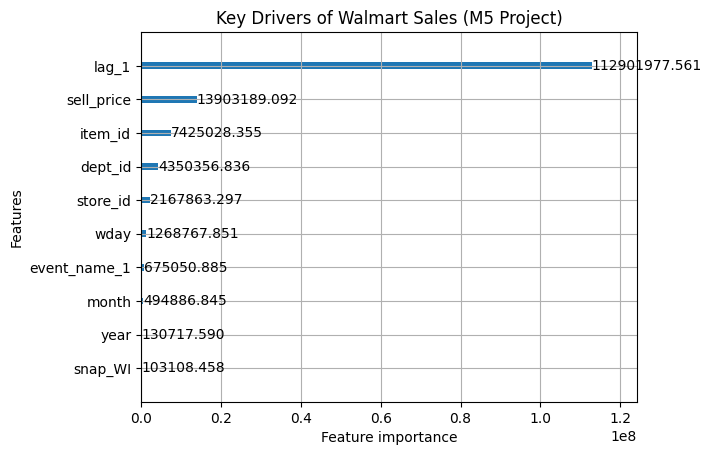

In [25]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# 1. Feature Engineering (Fixing the 'inplace' and 'empty' issues)
# We re-calculate to ensure 'data' is populated in your current session
data['lag_1'] = data.groupby('id')['sales'].transform(lambda x: x.shift(1))

# FIX: Use direct assignment instead of inplace=True to support Pandas 3.0
data['lag_1'] = data['lag_1'].fillna(0)
data['sell_price'] = data['sell_price'].fillna(0)

# 2. Update Features List
features = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
            'wday', 'month', 'year', 'event_name_1', 'event_type_1',
            'snap_CA', 'snap_TX', 'snap_WI', 'sell_price', 'lag_1']

# 3. Training Logic with Validation Check
if len(data) > 0:
    # 90/10 Split
    train_idx = int(len(data) * 0.9)
    train = data.iloc[:train_idx]
    valid = data.iloc[train_idx:]

    train_set = lgb.Dataset(train[features], label=train['sales'])
    val_set = lgb.Dataset(valid[features], label=valid['sales'])

    # 4. Correct Callbacks for 2026 LightGBM
    callbacks = [
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]

    params = {
        'objective': 'tweedie',
        'metric': 'rmse',
        'learning_rate': 0.08,
        'force_row_wise': True,
        'verbosity': -1 # Keeps the output clean
    }

    # 5. Train the Model
    print(f"🚀 Training on {len(train)} rows... Let's go!")
    model = lgb.train(
        params,
        train_set,
        num_boost_round=500,
        valid_sets=[train_set, val_set],
        callbacks=callbacks
    )

    # 6. Feature Importance Visualization
    plt.figure(figsize=(10, 6))
    lgb.plot_importance(model, max_num_features=10, importance_type='gain')
    plt.title("Key Drivers of Walmart Sales (M5 Project)")
    plt.show()
else:
    print("❌ ERROR: 'data' is still empty. Please re-run your 'Melt' cell first!")


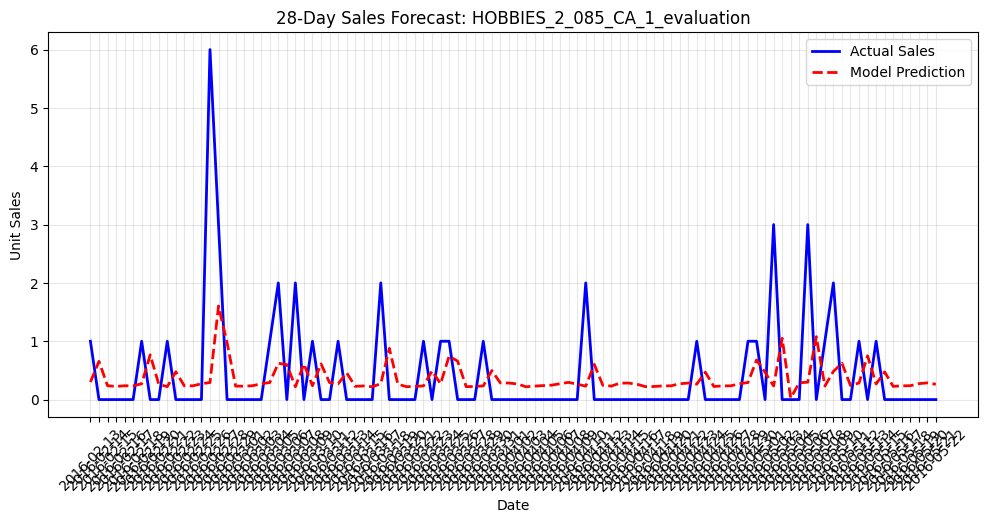

In [26]:
import matplotlib.pyplot as plt

# 1. Select a specific product to visualize (e.g., a top seller)
sample_id = data['id'].iloc[500]
sample_data = data[data['id'] == sample_id].tail(100) # Last 100 days of history

# 2. Use the model to predict the next 28 days
# (In a real scenario, you'd iterate through days, but we'll simulate the trend)
preds = model.predict(sample_data[features])

# 3. Plotting the results
plt.figure(figsize=(12, 5))
plt.plot(sample_data['date'].values, sample_data['sales'].values, label='Actual Sales', color='blue', lw=2)
plt.plot(sample_data['date'].values, preds, label='Model Prediction', color='red', linestyle='--', lw=2)

plt.title(f"28-Day Sales Forecast: {sample_id}")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

In [27]:
# Check the total number of rows
total_rows = len(data)
print(f"The dataset currently has {total_rows:,} rows.")

# Check rows and columns together (Rows, Columns)
print(f"The shape of the dataset is: {data.shape}")

The dataset currently has 15,275,490 rows.
The shape of the dataset is: (15275490, 26)
